# Learning from networks - Stonks

Start by importing the libraries we will use throughout the notebook.

In [5]:
import networkx as nx
import graph_library as gl
import matplotlib.pyplot as plt
from node2vec import Node2Vec
import igraph

%matplotlib inline

## Load graph and compute market capitalization

First of all let's start by loading the graph file and showing some basic information about it.
Note: we compute the longest path which in this specific case indicates how long is the path of ETFs buying other ETFs.

In [6]:
# Load Graph
G = nx.read_gml("out_graph.gml")
G_undirected = G.to_undirected() # Needed to compute the number of connected components

# Compute basic information about the graph
print(f"The graph contains {len(G.nodes())} nodes and {len(G.edges())} edges.")
print(f"There are {nx.number_connected_components(G_undirected)} connected components.")
print(f"Sizes: {[len(c) for c in sorted(nx.connected_components(G_undirected), key=len, reverse=True)]}")
print(f"Longest path in G: {gl.longest_path(G)}")
print(f"One of the ETFs that buys more components is {gl.max_out_degree_vertex(G)}.")
print(f"One of the most bought components is {gl.max_in_degree_vertex(G)}.")

The graph contains 25396 nodes and 396114 edges.
There are 6 connected components.
Sizes: [25189, 125, 38, 18, 13, 13]
Longest path in G: ['DBEU', 'IEUR', 'MCRO', 'VGK', 'SMCP', 'SCZ', 'GEM', 'HNDL', 'MLPA', 'PSXP']
One of the ETFs that buys more components is DFAX.
One of the most bought components is MSFT.


Now let's comoute the capitalization and print the top 20 nodes.

Capitalization of a stock is defined as the amount of money that the stock has been bought for by investors (including funds). In our case the capitalization of a component node is solely defined by funds purchases.

In [7]:
def compute_capitalization(G: nx.Graph):
    """
    Adds the 'capitalization' attribute to every node, which is the sum of the incoming edges weights.
    """
    for node in G.nodes():
        capitalization = 0
        for edge in G.in_edges(node):
            capitalization += G.get_edge_data(*edge)["weight"]
        G.nodes[node]["capitalization"] = capitalization

compute_capitalization(G)
k = 20
print(f"Top {k} nodes with highest capitalization: {gl.max_k_nodes(G, k, 'capitalization')}")

Top 20 nodes with highest capitalization: ['CPIN', 'AAPL', 'MSFT', 'AMZN', 'ADRO', 'GOOGL', 'FB', 'GOOG', 'TSLA', 'NVDA', 'JPM', 'UNVR', 'JNJ', 'V', 'UNH', 'HD', 'PG', 'BAC', 'MA', 'PYPL']


## Node-level features

### Betweenness centrality

We try to compute betweenness centralities of the nodes. The graph is too big to compute the exact betweenness centrality of each node, so we only use a small percentage of the nodes using the `percentage` parameter.

In [8]:
b_centralities = gl.betweenness_centrality_percent(G, percentage=0.02)
print(sorted(b_centralities.items(), key=lambda t: t[1], reverse=True)[:k])

[('GEM', 0.001237741904409041), ('VEA', 0.0009759014299965604), ('VWO', 0.0007348777005091896), ('SMCP', 0.0006997688620534076), ('CPI', 0.0006328135108390622), ('SCZ', 0.0005060488551757076), ('HNDL', 0.00038798373470493627), ('VGK', 0.00035660326847454705), ('IEUR', 0.0003444860587420205), ('ITOT', 0.0002922111731651592), ('CRBN', 0.00016824279667084925), ('IWM', 0.0001573683776801203), ('RALS', 0.00015542651714606155), ('MCRO', 0.00014144512130083862), ('HDG', 0.00013950326076677988), ('FAB', 0.00010493814326053433), ('EEM', 0.00010012232913606865), ('IWO', 9.748139880974876e-05), ('IWN', 9.538418943296532e-05), ('IEMG', 8.357767738588817e-05)]


### Closeness Centrality

Since the graph has more than one connected component, in order to compute closeness centrality for all the nodes, we use an algotithm found on the internet which basically computes the shortest paths using the Floyd — Warshall Method and uses the shortest path matrix to compute the closeness metric for each node. 

`gl.closeness_centrality_matrix(G)` takes approximately two minutes to be executed

In [9]:
k=20 # Redefine k in case previous code wasn't run
c_centralities = gl.closeness_centrality_matrix(G)
print(sorted(c_centralities.items(), key=lambda t: t[1], reverse=True)[:k])

[('FLCH', 0.3925908437613524), ('FLJH', 0.12381470128322727), ('FLJP', 0.12100044778931104), ('FLQS', 0.10921951387606549), ('FLQL', 0.030386053711497295), ('FLQH', 0.021701217297901722), ('FLQM', 0.019524774708658828), ('FLLA', 0.013310213897087787), ('FLKR', 0.010609925288797593), ('FLAU', 0.005769172407180744), ('FLTW', 0.005458232143275128), ('FLBR', 0.005106896958476084), ('FLHK', 0.0037305443794605955), ('FLLV', 0.0035766344016292697), ('FLGR', 0.0033738071048927264), ('BUYZ', 0.002014289322675759), ('IQM', 0.002002185430902044), ('XDAT', 0.0014866655346868582), ('HELX', 0.0013572976578982699), ('FLSW', 0.0013049781760334797)]


As an approximation we compute the closeness centrality of the nodes in a small random connected subgraph.
We devised our own algorithm to draw a connected sample of `k` nodes from the graph `G`: `connected_random_subgraph(G, n)`. 

In [11]:
sub_G = gl.connected_random_subgraph(G, 8000)
c_centralities = nx.closeness_centrality(sub_G, distance="weight")
print(sorted(c_centralities.items(), key=lambda t: t[1], reverse=True)[:k])

There are 1 components with more than 8000 nodes.
[('BES', 0.9325174970880684), ('HUV1', 0.014570585892001069), ('DOF5', 0.0024284309820001783), ('FRW', 0.0020815122702858672), ('1863', 0.0012142154910000892), ('198', 0.0006200249315745137), ('SUGI', 0.00040473849700002975), ('JUSD9', 0.0003237907976000238), ('1228', 6.946644048629832e-05), ('1885615D', 2.2279183321102555e-05), ('ALTERNAB', 1.5906753157206408e-05), ('1884932D', 1.4599785462926925e-05), ('4USD69654Z', 1.1527362256329961e-05), ('LGNXZ', 7.325583656109135e-06), ('1882388', 6.020903261157467e-06), ('PLN', 5.479723915758206e-06), ('USD1868USD', 5.068029875478633e-06), ('PX1', 4.934163864544893e-06), ('139USD5USD', 4.896030205645521e-06), ('CTP', 4.038410723947081e-06)]


### Clustering coefficients

The computation for the exact clustering coefficient is doable ...

In [12]:
nodes_clustering_coeff = nx.clustering(G, weight="weight")

# Print top k nodes with highest clustering coefficient
print(f"Top {k} nodes by clustering coefficient:")
print(sorted(nodes_clustering_coeff.items(), key=lambda t: t[1], reverse=True)[:k])
print(f"\nGlobal clustering coefficient: {nx.transitivity(G)}")

Top 20 nodes by clustering coefficient:
[('RWVG', 2.220278602733271e-05), ('UNA', 1.9880340687835788e-05), ('SSI', 1.5219529225139582e-05), ('HPG', 1.2501223578956097e-05), ('PDR', 1.2427193087025836e-05), ('CRHl', 1.2137344349100604e-05), ('VIC', 1.1967758246053812e-05), ('KRZ', 1.1909451311225256e-05), ('BCM', 1.1672895376409549e-05), ('RWGV', 1.1043518322844037e-05), ('VHM', 1.0180368464746611e-05), ('VCI', 8.455830606685144e-06), ('NVL', 8.304115970363736e-06), ('HSG', 8.276992510958094e-06), ('GEX', 7.798399073501852e-06), ('EXK', 7.639429907146357e-06), ('VCB', 7.093919710666592e-06), ('NOVO', 6.784985924541268e-06), ('JETl', 6.676593093953429e-06), ('DGC', 6.654628072496844e-06)]

Global clustering coefficient: 9.24110477412097e-05


## Cycles

It might be interesting to find whether there are cycles in the graph. There shouldn't be, but you never know.

There is actually a cycle in the graph: [('BFIT', 'BFIT', 'forward')]


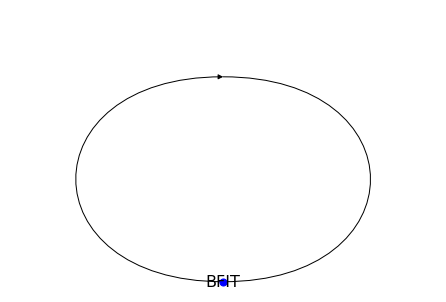

In [13]:
cycle = list(nx.find_cycle(G, orientation="original"))
if cycle:
    print(f"There is actually a cycle in the graph: {cycle}")
    nx.draw(G.subgraph(cycle[0]), with_labels=True, node_color="blue", node_size=50, font_size=16)
else:
    print("There is no cycle in the graph.")

Although there shouldn't be cycles in the graph there may be some, this is due to the incorrect parsing or cleaning of the dataset.

## Embeddings

Let's try some embeddings now

### Node2Vec

Computing transition probabilities:  35%|███▌      | 8911/25396 [00:00<00:00, 19043.76it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/node2vec/node2vec.py:132: RuntimeWarning: invalid value encountered in true_divide
  d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()
Generating walks (CPU: 2): 100%|██████████| 150/150 [00:09<00:00, 15.13it/s]


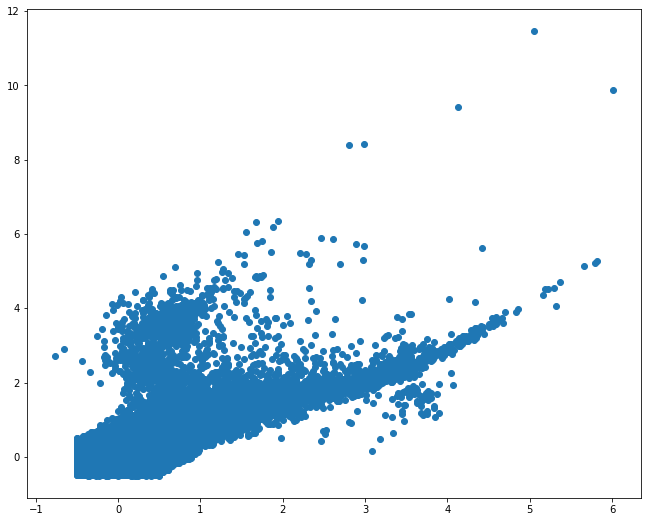

In [14]:
node2vec = Node2Vec(G, dimensions=2, walk_length=5, num_walks=300, workers=2)
model = node2vec.fit(window=10, min_count=1)
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(model.wv.vectors[:, 0], model.wv.vectors[:, 1])

## Graphlets and Motifs

In [17]:
# Recompute sub_G
sub_G = gl.connected_random_subgraph(G, 40)
# Convert to igraph
igraph_sub_G = igraph.Graph.from_networkx(sub_G)
esu_k3 = gl.enumerate_subgraphs(igraph_sub_G, 3)
print(f"there are {esu_k3} 3-nodes-graphs in the subgraph")

There are 2 components with more than 40 nodes.
there are [{0, 32, 27}, {0, 26, 27}, {0, 27, 22}, {0, 27, 13}, {0, 27, 7}, {0, 27, 12}, {0, 17, 27}, {0, 33, 27}, {0, 27, 4}, {0, 27, 36}, {0, 27, 28}, {0, 2, 27}, {0, 16, 27}, {0, 27, 5}, {0, 11, 27}, {0, 27, 29}, {0, 27, 20}, {0, 3, 27}, {0, 34, 27}, {0, 25, 27}, {0, 19, 27}, {0, 27, 15}, {0, 27, 14}, {0, 18, 27}, {0, 27, 31}, {0, 9, 27}, {0, 27, 38}, {0, 1, 27}, {0, 27, 21}, {0, 24, 27}, {0, 27, 6}, {0, 27, 30}, {0, 27, 39}, {0, 10, 27}, {0, 27, 37}, {0, 27, 23}, {0, 8, 27}, {0, 35, 27}, {0, 19, 36}, {0, 19, 20}, {0, 19, 29}, {0, 19, 15}, {0, 19, 37}, {0, 32, 19}, {0, 2, 19}, {0, 19, 5}, {0, 24, 19}, {0, 3, 19}, {0, 19, 13}, {0, 11, 19}, {0, 8, 19}, {0, 10, 19}, {0, 19, 6}, {0, 17, 19}, {0, 19, 28}, {0, 19, 12}, {0, 35, 19}, {0, 1, 19}, {0, 18, 19}, {0, 19, 22}, {0, 26, 19}, {0, 19, 23}, {0, 19, 4}, {0, 19, 31}, {0, 19, 14}, {0, 19, 21}, {0, 19, 7}, {0, 34, 19}, {0, 16, 19}, {0, 33, 19}, {0, 25, 19}, {0, 9, 19}, {0, 19, 38}, {0, 19, 39